# Calculate angular Cl's with CCL
In this example, we will calculate the lensing angular power spectrum for an example cosmology.

In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
%matplotlib inline

### Set up a Cosmology object
We begin by creating a new `Cosmology` object with a set of cosmology parameters:

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

### Define a source number density
The angular power spectrum is weighted by the source number density as a function of redshift, dN/dz. We define an example here.

In [3]:
z = np.linspace(0., 3., 200)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744

Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution

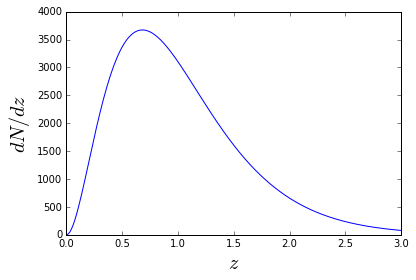

In [4]:
plt.plot(z, dNdz)
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$dN/dz$',fontsize=20)
plt.show()

### Create ClTracer objects
CCL manages auto- and cross-spectrum calculations through `ClTracer` objects. For the sake of this example we will define two separate tracers, but both will effectively be the same tracer (so we end up calculating the auto-spectrum).

In [5]:
lens1 = ccl.ClTracerLensing(cosmo, False, z=z, n=dNdz)
lens2 = ccl.ClTracerLensing(cosmo, False, n=(z, dNdz))

The argument set to `False` in these statements specifies that we are ignoring intrinsic alignments.

Note how there are two different ways of specifying the number density, `dNdz`. The first one specifies the `z` and `dNdz` arrays as separate arguments. This is useful if you need to specify several redshift functions that are gridded onto the _same_ `z` array. For example, if we wanted to include intrinsic alignments, we could have created the `ClTracer` object like so:

In [6]:
bias_ia = np.ones(z.size) # Intrinsic alignment bias factor
f_red = 0.5 * np.ones(z.size) # Fraction of red galaxies
lens1_ia = ccl.ClTracerLensing(cosmo, True, z=z, n=dNdz, bias_ia=bias_ia, f_red=f_red)

The redshift functions are often binned quite differently, so sharing the same `z` array doesn't make sense. Instead, you can specify each function as a tuple, of the form `(z_array, function_array)`. Each pair can be binned in redshift however you like, e.g.

In [7]:
z_ia = np.linspace(0., 3., 5) # Only 5 redshift bins
bias_ia2 = np.ones(z_ia.size)
lens2_ia = ccl.ClTracerLensing(cosmo, True, n=(z, dNdz), bias_ia=(z_ia, bias_ia), f_red=(z, f_red))

The bias, red fraction, redshift distribution etc. are stored inside the `ClTracer` object when you create it. The arrays can be accessed as parameters of the `ClTracer` object, e.g. `lens2_ia.z_n` and `lens2_ia.n` would return the dN/dz array and its redshift sampling.

### Calculate the angular power spectrum
We can now calculate the angular power spectrum for the tracer(s). Internally, the calculation will be performed up to some $\ell_{\rm max}$, which will be relatively slow when first run. If we call the `angular_cl` function again with a different $\ell$ sampling, it will be quickly evaluated from a spline though.

In [8]:
ell = np.arange(2, 100)
cls = ccl.angular_cl(cosmo, lens1, lens2, ell)

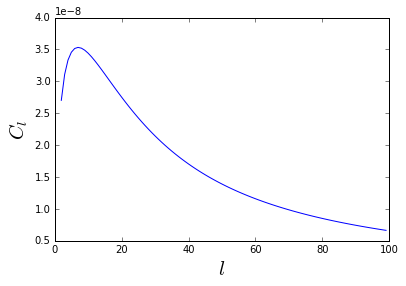

In [9]:
plt.plot(ell, cls)
plt.xlabel(r'$l$', fontsize=20)
plt.ylabel(r'$C_l$', fontsize=20)
plt.show()

#### CMB lensing cross-correlation example
CCL also supports auto- and cross-correlations for CMB lensing. This is treated as another "tracer" within CCL, so you can perform the cross-correlation between the lensing samples defined above and CMB lensing as follows:

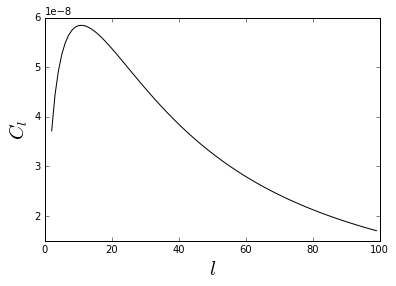

In [10]:
cmbl = ccl.ClTracerCMBLensing(cosmo, 1090.)
cls_cmb_cross_lens1 = ccl.angular_cl(cosmo, lens1, cmbl, ell)

plt.plot(ell, cls_cmb_cross_lens1, 'k-')
plt.xlabel(r'$l$', fontsize=20)
plt.ylabel(r'$C_l$', fontsize=20)
plt.show()